In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("nifty_ohlc_formatted.xlsx", parse_dates=["Date"])
df.sort_values(["Ticker","Date"], inplace=True)
df.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2019-01-01,ADANIENT.NS,158.848918,160.280447,153.468395,155.245453,4726656
1,2019-01-02,ADANIENT.NS,154.998624,155.837795,150.555988,152.876038,2735262
2,2019-01-03,ADANIENT.NS,152.925384,154.110099,148.384032,150.555984,2758876
3,2019-01-04,ADANIENT.NS,150.161117,152.036890,148.087880,150.605377,2777308
4,2019-01-07,ADANIENT.NS,150.950890,152.481135,148.334678,149.321930,2714218


In [3]:
df["LogRet"] = np.log(df.groupby("Ticker")["Close"].pct_change()+1)
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,LogRet
0,2019-01-01,ADANIENT.NS,158.848918,160.280447,153.468395,155.245453,4726656,NaN
1,2019-01-02,ADANIENT.NS,154.998624,155.837795,150.555988,152.876038,2735262,-0.015380
2,2019-01-03,ADANIENT.NS,152.925384,154.110099,148.384032,150.555984,2758876,-0.015292
3,2019-01-04,ADANIENT.NS,150.161117,152.036890,148.087880,150.605377,2777308,0.000328
4,2019-01-07,ADANIENT.NS,150.950890,152.481135,148.334678,149.321930,2714218,-0.008558


In [4]:
rv_window = 21
df["RV"] = (
    df.groupby("Ticker")["LogRet"]
      .rolling(rv_window).apply(lambda r: np.sqrt(np.mean((100*r)**2)), raw=True)
      .reset_index(level=0, drop=True)
)
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,LogRet,RV
0,2019-01-01,ADANIENT.NS,158.848918,160.280447,153.468395,155.245453,4726656,NaN,NaN
1,2019-01-02,ADANIENT.NS,154.998624,155.837795,150.555988,152.876038,2735262,-0.015380,NaN
2,2019-01-03,ADANIENT.NS,152.925384,154.110099,148.384032,150.555984,2758876,-0.015292,NaN
3,2019-01-04,ADANIENT.NS,150.161117,152.036890,148.087880,150.605377,2777308,0.000328,NaN
4,2019-01-07,ADANIENT.NS,150.950890,152.481135,148.334678,149.321930,2714218,-0.008558,NaN


Discretise: Converts a continuous time series (like log returns) into categorical bins for entropy-based calculations - quartile based

TE: Measures how much knowing the past of Y improves the prediction of the future of X

ETE: Improves TE by removing the part that could be explained by random chance 

In [5]:
# quantile-based binning 
def discretise(series, bins=3):
    q = np.linspace(0,1,bins+1)
    return pd.qcut(series, q, labels=False, duplicates="drop")

# computes the raw TE from 𝑌 → 𝑋 using triple and pair frequencies 
def transfer_entropy(x, y, lag=1):
    # x[t+1] ~ future of X, x[t] ~ past X, y[t] ~ past Y
    # Both x and y already discretised
    from collections import Counter
    trip = list(zip(x[lag:], x[:-lag], y[:-lag]))
    pair = list(zip(x[lag:], x[:-lag]))
    p_trip = Counter(trip)
    p_pair = Counter(pair)
    p_x = Counter(x[lag:])
    N = len(trip)
    te = 0.0
    for (xf,xp,yp), c in p_trip.items():
        p_xyz = c/N
        p_xf_xp = p_pair[(xf,xp)]/N
        p_xf = p_x[xf]/N
        te += p_xyz * np.log2(p_xyz*p_xf / (p_xf_xp*p_xf))
    return te

In [ ]:
def effective_transfer_entropy(x_raw, y_raw, m=50, bins=3, lag=1):
    """
    Compute Effective Transfer Entropy (ETE) from y → x.
    Subtracts shuffled baseline and computes Z-score.
    """
    # Discretize
    x = discretise(x_raw, bins)
    y = discretise(y_raw, bins)
    
    # Drop NaNs due to discretisation or lag
    valid = ~(pd.isna(x) | pd.isna(y))
    x, y = x[valid], y[valid]

    te_actual = transfer_entropy(x, y, lag)

    te_shuffled = []
    for _ in range(m):
        y_shuffled = np.random.permutation(y)
        te_shuffled.append(transfer_entropy(x, y_shuffled, lag))

    mu = np.mean(te_shuffled)
    sigma = np.std(te_shuffled, ddof=1)
    ete = te_actual - mu
    z = (te_actual - mu) / sigma if sigma > 0 else np.nan

    return {"TE": te_actual, "ETE": ete, "Z": z, "mu": mu, "sigma": sigma}

In [7]:
# Build wide-form panels using your actual column names
logret_panel = df.pivot(index='Date', columns='Ticker', values='LogRet')
rv_panel     = df.pivot(index='Date', columns='Ticker', values='RV')

tickers = logret_panel.columns.tolist()

# Prepare empty output matrices
ete_ret = pd.DataFrame(index=tickers, columns=tickers)
z_ret   = pd.DataFrame(index=tickers, columns=tickers)

# Loop over all stock pairs: Y → X
for y in tickers:  # source
    for x in tickers:  # target
        if x == y:
            continue

        x_series = logret_panel[x].dropna()
        y_series = logret_panel[y].reindex(x_series.index).dropna()
        x_series = x_series.reindex(y_series.index).dropna()
        y_series = y_series.reindex(x_series.index)

        if len(x_series) < 50:
            continue

        res = effective_transfer_entropy(
            x_raw = x_series.values,
            y_raw = y_series.values,
            m = 100
        )

        ete_ret.loc[x, y] = res['ETE']
        z_ret.loc[x, y]   = res['Z']

# Save results
ete_ret.to_excel("ETE_LogRet.xlsx")
z_ret.to_excel("Zscore_LogRet.xlsx")


HURST [0,1] - quantifies persistance in time series 
H = 0.5: Pure noise - Brownian Motion
H > 0.5: Persistance - trends continue, momentum dominated regime
H < 0.5: anti-persistance - trends reverse - mean reverting

In [8]:
def hurst_rs(series, min_window=10, max_window=None, num_windows=10):
    N = len(series)
    if max_window is None:
        max_window = N // 2
    window_sizes = np.logspace(np.log10(min_window), np.log10(max_window), num=num_windows, dtype=int)
    rs = []
    for w in window_sizes:
        if w >= N:
            continue
        n_segments = N // w
        rs_w = []
        for i in range(n_segments):
            seg = series[i*w:(i+1)*w]
            mean = np.mean(seg)
            dev = seg - mean
            cumdev = np.cumsum(dev)
            R = np.max(cumdev) - np.min(cumdev)
            S = np.std(seg)
            if S > 0:
                rs_w.append(R/S)
        if len(rs_w) > 0:
            rs.append(np.mean(rs_w))
    # Linear fit to log-log plot
    log_rs = np.log(rs)
    log_window = np.log(window_sizes[:len(rs)])
    H, _ = np.polyfit(log_window, log_rs, 1)
    return H

In [9]:
# 1) Load the real NIFTY50 index
idx = pd.read_excel("NIFTY50_index_prices.xlsx", parse_dates=["Date"])
idx = idx.sort_values("Date").set_index("Date")

# 2) Compute its log‐returns
# Ensure 'Close' is numeric
idx["Close"] = pd.to_numeric(idx["Close"], errors="coerce")

# Optionally, drop rows where 'Close' is NaN (if you want to skip those dates)
# idx = idx.dropna(subset=["Close"])

# Now compute log-returns
idx["IndexRet"] = np.log(idx["Close"] / idx["Close"].shift(1))
# 3) 250‐day R/S on those index returns
H_global = (
    idx["IndexRet"]
      .rolling(window=250)
      .apply(lambda seg: hurst_rs(seg[~np.isnan(seg)]), raw=True)
      .rename("H_global")
)

#  10‐day lookback, s=6 regime detection
s = 6
regime = pd.Series(index=H_global.index, dtype="object")
for t in range(len(H_global)):
    if t < 9 or H_global.iloc[t-9:t+1].isna().any():
        regime.iloc[t] = np.nan
    else:
        block = H_global.iloc[t-9:t+1]
        if (block > 0.5).sum() >= s:
            regime.iloc[t] = "Above"
        elif (block < 0.5).sum() >= s:
            regime.iloc[t] = "Below"
        else:
            regime.iloc[t] = regime.iloc[t-1]


# Merge back into your main df by Date
df = df.merge(
    pd.concat([H_global, regime.rename("Regime")], axis=1).reset_index(),
    on="Date", how="left"
)
df.to_excel("nifty_ohlc_with_regimes.xlsx", index=False)


df = df.drop(columns=[col for col in ['H_global', 'Regime'] if col in df.columns])
df = df.merge(
    pd.concat([H_global, regime.rename("Regime")], axis=1).reset_index(),
    on="Date", how="left"
)

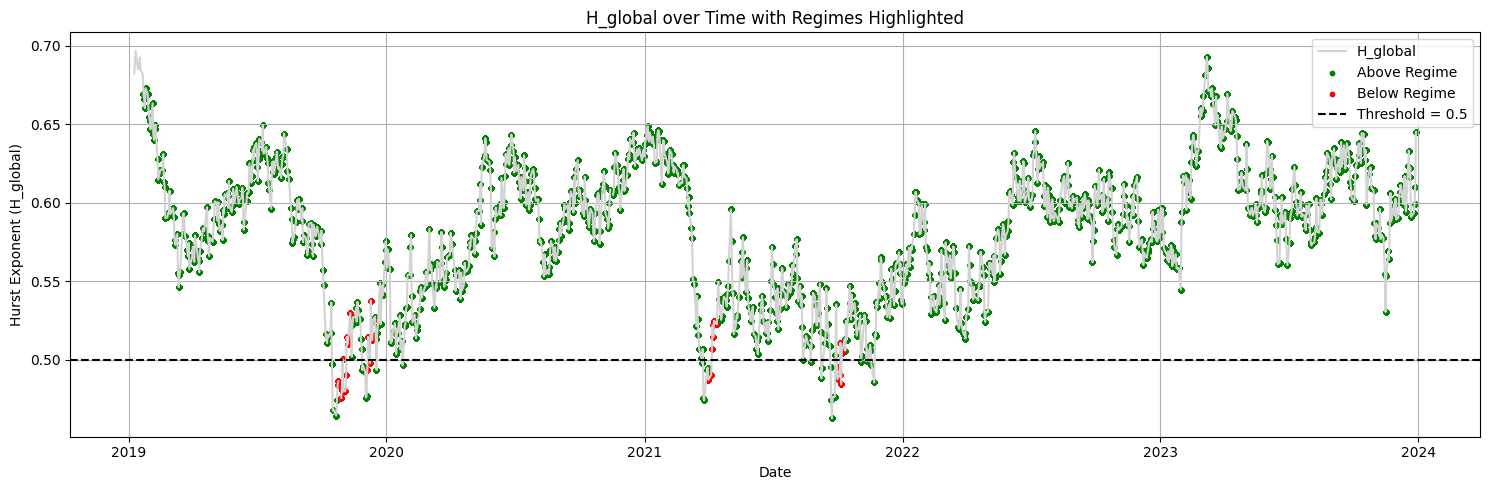

In [10]:
# Ensure sorted by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")

# Plot H_global over time, color-coded by regime
plt.figure(figsize=(15, 5))
above_mask = df['Regime'] == "Above"
below_mask = df['Regime'] == "Below"

plt.plot(df['Date'], df['H_global'], color='lightgray', label='H_global')
plt.scatter(df.loc[above_mask, 'Date'], df.loc[above_mask, 'H_global'],
            color='green', s=10, label='Above Regime')
plt.scatter(df.loc[below_mask, 'Date'], df.loc[below_mask, 'H_global'],
            color='red', s=10, label='Below Regime')

plt.axhline(0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.title("H_global over Time with Regimes Highlighted")
plt.xlabel("Date")
plt.ylabel("Hurst Exponent (H_global)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import pandas as pd
import torch

# 1) Load your precomputed ETE matrix
ete_ret = pd.read_excel("ETE_LogRet.xlsx", index_col=0)

# 2) Collect *all* positive off-diagonal entries
#    here we take upper triangle (i<j) to avoid duplicates,
#    but you could flatten and then filter for >0
mask_upper = np.triu(np.ones(ete_ret.shape, dtype=bool), k=1)
all_ete    = ete_ret.values[mask_upper]
nonzero    = all_ete[all_ete > 0]

# 3) Compute the global μ and σ
mu_global    = nonzero.mean()
sigma_global = nonzero.std(ddof=1)

# 4) Build a global Z‐score matrix
Z = (ete_ret - mu_global) / sigma_global

# 5) Threshold: keep edges where ETE>0 *and* Z>1.96
keep = (ete_ret > 0) & (Z > 1.96)

# 6) Extract source/target node pairs and weights
src, dst = np.where(keep.values)
weights  = ete_ret.values[keep.values].astype(float)

# 7) Build PyTorch‐Geometric edge_index & edge_weight
edge_index  = torch.tensor([src, dst], dtype=torch.long)
edge_weight = torch.tensor(weights, dtype=torch.float)

print(f"Kept {len(weights)} edges (Z>1.96).")


Kept 72 edges (Z>1.96).


/var/folders/ds/g2r2qb3j79n0w3l60r5y3_qr0000gn/T/ipykernel_9002/1919002027.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  edge_index  = torch.tensor([src, dst], dtype=torch.long)
